In [7]:
import os
import sys
import datetime
import scanorama
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sps
import matplotlib.pyplot as plt

from pathlib import Path
from os.path import join
from functools import reduce
from sklearn.metrics import pairwise_distances

def py_read_data(_dir, fname):
    # read data in sps
    # saved in (cells, genes)
    sps_X = sps.load_npz(join(_dir, fname+'.npz'))
    # read gene names
    with open(join(_dir, fname+'_genes.pkl'), 'rb') as f:
        genes = pickle.load(f)
    # read cell names
    with open(join(_dir, fname+'_cells.pkl'), 'rb') as f:
        cells = pickle.load(f)

    return sps_X, cells, genes

sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()

sc.settings.set_figure_params(dpi=80)
# %matplotlib inline

dno = 'dataset4' # Pancreas
data_dir = join('/home/yxh/gitrepo/Batch-effect-removal-benchmarking-master/Data', dno)
out_dir  = join('/home/yxh/gitrepo/Batch-effect-removal-benchmarking-master/Output', dno)

filename = "myData_pancreatic_5batches"
metadata_filename = "mySample_pancreatic_5batches.txt"

sc.settings.set_figure_params(dpi=80)
sc.settings.figdir = Path(f'/home/yxh/gitrepo/Batch-effect-removal-benchmarking-master/Output/{dno}/scanorama')
sc.settings.figdir.mkdir(parents=True, exist_ok=True)

min_cells = 3
npcs = 50
sf = 1e4
n_hvgs = 2000
n_neighs = 10

batch_label = "batchlb"
celltype_label = "CellType"
########################
# read data 
expr_mat, genes, cells = py_read_data(data_dir, filename)  # count data
metadata = pd.read_csv(join(data_dir, metadata_filename), sep="\t", index_col=0)

metadata['CellType'] = metadata['celltype']
metadata = metadata.drop(['celltype'], axis=1)

# prepare input for scanorama
adata = sc.AnnData(sps.csr_matrix(expr_mat.T))
adata.obs_names = cells
adata.var_names = genes
adata.obs[batch_label] = metadata.loc[adata.obs_names, batch_label].astype('category')
adata.obs[celltype_label] = metadata.loc[adata.obs_names, celltype_label].astype('category')

# preprocessing
sc.pp.filter_genes(adata, min_cells=min_cells) 
sc.pp.normalize_total(adata, target_sum=sf)
sc.pp.log1p(adata)

# find var.gene by batch
sc.pp.highly_variable_genes(adata, n_top_genes=n_hvgs, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key=batch_label)
# df_var_sel = adata.var.highly_variable_nbatches >= 1   # take the union of batch.var.genes
# var_genes = df_var_sel.index[df_var_sel]
# print(f'{len(n_h)} selected')

# scanorama not recommend use 'scale' here
adata = adata[:, adata.var.highly_variable].copy()
# sc.pp.scale(adata, max_value=None)

# split by batch
Xs = []
for bi in adata.obs.batchlb.unique():
    cell_bi = adata.obs.batchlb == bi
    adata_batch = adata[cell_bi].copy()
    sc.pp.scale(adata_batch)
    
    Xs.append(adata_batch)
    print(f'n of {bi} = {cell_bi.sum()}, {len(Xs[-1])}')

corrected = scanorama.correct_scanpy(Xs, return_dimred=True, dimred=npcs)

ada_sca = sc.concat(corrected)
ada_sca.obsm["X_emb"] = ada_sca.obsm['X_scanorama']

from evaluation import scib_process
ada_sca.obs[[batch_label, celltype_label]] = ada_sca.obs[[batch_label, celltype_label]].astype('category')

tmp_res = scib_process(ada_sca,
                        batch_key=batch_label,
                        label_key=celltype_label,
                        nmi_=True, nmi_method='arithmetic', save_nmi=None,
                        ari_=True,
                        silhouette_=True, si_metric='euclidean',
                        # pcr_=pcr_,
                        # cell_cycle_=cell_cycle_, organism=organism,
                        isolated_labels_=False, n_isolated=None,
                        graph_conn_=False,
                        type_='emb',
                        subsample=0.5,  # for kBET
                        kBET_ = False,   
                        clisi_= False,
                        ilisi_= False)

tmp_res.to_csv(join(out_dir,  f'scanorama/{dno}_emb_wtScale_eval.csv'), index=True, sep=',')

/home/yxh/.local/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


n of Baron_b1 = 8569, 8569
n of Mutaro_b2 = 2122, 2122
n of Segerstolpe_b3 = 2127, 2127
n of Wang_b4 = 457, 457
n of Xin_b5 = 1492, 1492
Found 2000 genes among all datasets
[[0.         0.39114043 0.6022567  0.07658643 0.09316354]
 [0.         0.         0.61781338 0.05032823 0.00335121]
 [0.         0.         0.         0.80743982 0.28284182]
 [0.         0.         0.         0.         0.57330416]
 [0.         0.         0.         0.         0.        ]]
Processing datasets (2, 3)
Processing datasets (1, 2)
Processing datasets (0, 2)
Processing datasets (3, 4)
Processing datasets (0, 1)
Processing datasets (2, 4)
NMI...
ARI...
Silhouette score...
Graph connectivity...


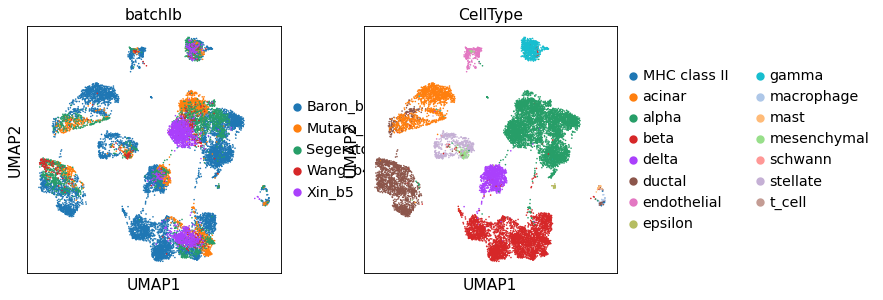

In [8]:
sc.pp.neighbors(ada_sca, n_neighbors=n_neighs, use_rep='X_scanorama') # use raw.X    
sc.tl.umap(ada_sca)
sc.pl.umap(ada_sca, color=[batch_label, celltype_label])

os.makedirs(join(out_dir, 'scanorama/h5ad'), exist_ok=True)
ada_sca.write(join(out_dir, f'scanorama/h5ad/{dno}_emb_wtScale.h5ad'))